# Classic machine learning approach for sentiment analysis

This notebook presents classic machine learning approach for predicting reviews sentiment. By classic machine learning approach the author means  everything that is not neural networks (algorithms like Decision Trees, Logistic Regression and so on). The data was analized and prepared for modelling in `Data_analysis.ipynb` notebook.

Two cases were considered:
 1. Binary classification where only positive and negative reviews were taken into account
 2. Muliclass classification where all three kinds of reviews were taken into account (positive, neutral and negative)
 
__Note__: Because almost 93% of the reviews are positive some imbalanced classification problem steps were undertaken. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, plot_roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, RUSBoostClassifier

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [4]:
pd.set_option('display.max_rows', 500)

__Loading prepared data__

In [5]:
data = pd.read_csv('Data_ML.csv', index_col='Unnamed: 0')

In [6]:
data.head()

,rating,review
0,1,wireless gaming headset gaming headset ticks ...
1,0,good big head low budget easy setup rated 6 ho...
2,1,mezumiwireless gaming headset originally bough...
3,1,hw s2 great headset 2nd mezumi headset kills f...
4,1,best headphones ive purchased entire life prob...


In [7]:
def model_summary(model, X_test, y_test):
    """
    Function that prints classification report and confusion matrix for a given model
    """
    
    y_pred = model.predict(X_test)
    print('\nconfusion matrix\n', confusion_matrix(y_test, y_pred))

    print('\nclassification report\n',classification_report(y_test, y_pred))

In [8]:
#variable for loading the trained models, 
#if it is True the models are loaded from saved pickle files, otherwise the models are fitted (training may take a few days!!!)
load = True

# 1. Binary classification

__In this section only positive and negative reviews are used for building and testing models__<br>

__preparing data for binary classification__

In [9]:
#Keeping only positive and negative reviews
data_preprocessed_binary = data[data.rating != 0]

#Words that appear in less than 50 reviews are removed
min_df = 50

X = data_preprocessed_binary.loc[:, 'review']
y = data_preprocessed_binary.loc[:, 'rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=100)

## 1.1 No operations regarding class imbalance

### 1.1.1. Benchmark model - Logistic Regression

__Three different f1-scoring were tesed in GridSearchCV, it turned out that it does not make any difference and two other models are not shown__

In [10]:
modelLR = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df)),
    ("model", LogisticRegression(max_iter=10_000, penalty='l2'))
])

paramsLR = { "tfidf_vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
             "model__C": [0.1, 1, 10],
             "model__class_weight":[{1:1, -1:1}, {1:1, -1:10}, {1:1, -1:20}]}

optimizerLR = GridSearchCV(modelLR, paramsLR, cv=10, scoring='f1_weighted')

#if load is True the model is loaded
if load:
    optimizerLR = pickle.load(open("models/111LogReg_benchamrk.pkl", 'rb'))

#if load is False the model is trained    
else:
    optimizerLR.fit(X_train, y_train)

__Models with two other f1-scoring and ROC curves for all three LogReg models__

In [11]:
# optimizerLR2 = GridSearchCV(modelLR, paramsLR, cv=10, scoring='f1_micro')
# optimizerLR2.fit(X_train, y_train)

# optimizerLR3 = GridSearchCV(modelLR, paramsLR, cv=10, scoring='f1_macro')
# optimizerLR3.fit(X_train, y_train)

# fig, ax = plt.subplots(figsize=(20,10))
# plot_roc_curve(optimizerLR, X_test, y_test, ax=ax)
# plot_roc_curve(optimizerLR2, X_test, y_test, ax=ax)
# plot_roc_curve(optimizerLR3, X_test, y_test, ax=ax)

### 1.1.2. XGBoost

In [12]:
modelXGB= Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1,2))),
    ("model", XGBClassifier(n_estimators=500, max_depth=30, objective='binary:logistic'))
])

paramsXGB = {
             "model__reg_lambda":[0.1, 1, 10],
             "model__learning_rate":[0.1, 0.5, 0.9]
            }

optimizerXGB = GridSearchCV(modelXGB, paramsXGB, cv=5, scoring='f1_weighted')

if load:
    optimizerXGB = pickle.load(open("models/112XGB.pkl", 'rb'))
else:
    optimizerXGB.fit(X_train, y_train)

### 1.1.3. SVM

Note: This model had to be limited, the author tried more variables in GridSearch parameters but the model was being fitted for over 7 days without success

In [13]:
modelSVM = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1,2))),
    ("model", SVC(probability=True, kernel='rbf'))
])

paramsSVM = {"model__C":[0.1, 1, 10]}

optimizerSVM = GridSearchCV(modelSVM, paramsSVM, cv=5, scoring='f1_weighted')

if load:
    optimizerSVM = pickle.load(open("models/113SVM.pkl", 'rb'))
else:
    optimizerSVM.fit(X_train, y_train)

## 1.2. Undersampling
__The training set is undersampled (number of positive ratings is downgraded in order to obtain balanced labels)__

In [14]:
X = data_preprocessed_binary.loc[:, 'review']
y = data_preprocessed_binary.loc[:, 'rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [15]:
data_train = pd.concat([X_train, y_train], axis=1)

In [16]:
#negative reviews from training set
data_minor = data_train[data_train['rating'] == -1]

#number of negative reviews
minor_size = data_minor.shape[0]

#downsampling the positive ratings
data_major = data_train[data_train['rating'] == 1].sample(n=minor_size)

data_train2 = pd.concat([data_minor, data_major])
X_train = data_train2.loc[:, 'review']
y_train = data_train2.loc[:, 'rating']

In [17]:
print('bad and good reviews after undersampling - percentage and quantity shares\n')
print(data_train2['rating'].value_counts(normalize=True))
print(data_train2['rating'].value_counts(normalize=False))

bad and good reviews after undersampling - percentage and quantity shares

 1    0.5
-1    0.5
Name: rating, dtype: float64
 1    1621
-1    1621
Name: rating, dtype: int64


### 1.2.1. XGBoost

In [18]:
modelXGB_US = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1,2))),
    ("model", XGBClassifier(objective='binary:logistic'))
])

paramsXGB_US = {"model__n_estimators":[100, 300, 500],
                "model__max_depth":[10, 30],
                "model__reg_lambda":[0.1, 1, 10],
                "model__learning_rate":[0.01, 0.1, 0.5, 0.9],
               }

optimizerXGB_US = GridSearchCV(modelXGB_US, paramsXGB_US, cv=5, scoring='f1_macro')

if load:
    optimizerXGB_US = pickle.load(open("models/121XBG.pkl", 'rb'))
else:
    optimizerXGB_US.fit(X_train, y_train)

### 1.2.2. SVM

In [19]:
modelSVM_US = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df)),
    ("model", SVC())
])

paramsSVM_US = {"tfidf_vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
             "model__C":[0.1, 1, 10],
             "model__kernel":['rbf','poly','linear'],
             "model__degree":[1,2,3,4,5,6],
            }

optimizerSVM_US = GridSearchCV(modelSVM_US, paramsSVM_US, cv=5, scoring='f1_macro')

if load:
    optimizerSVM_US = pickle.load(open("models/122SVM.pkl", 'rb'))
else:
    optimizerSVM_US.fit(X_train, y_train)

### 1.2.3. KNN

In [20]:
modelKNN_US = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df)),
    ("model", KNeighborsClassifier())
])

paramsKNN_US = {"tfidf_vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
             "model__n_neighbors":[3, 5, 10, 15]
            }

optimizerKNN_US = GridSearchCV(modelKNN_US, paramsKNN_US, cv=10, scoring='f1_macro')
if load:
    optimizerKNN_US = pickle.load(open("models/123KNN.pkl", 'rb'))
else:
    optimizerKNN_US.fit(X_train, y_train)

## 1.3. Imblearn library
__Library dedicated for imbalanced problems__

In [21]:
X = data_preprocessed_binary.loc[:, 'review']
y = data_preprocessed_binary.loc[:, 'rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

### 1.3.1. Balanced Random Forest

In [22]:
modelBRF = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1,2))),
    ("model", BalancedRandomForestClassifier(replacement=True))
])

paramsBRF = {"model__max_depth": [10, 25],
             "model__n_estimators": [100, 200, 500],
             "model__class_weight": [{1:1, -1:1}, {1:1, -1:10}, {1:1, -1:20}]}

optimizerBRF = GridSearchCV(modelBRF, paramsBRF, cv=5, scoring='f1_weighted')
if load:
    optimizerBRF = pickle.load(open("models/131BRF.pkl", 'rb'))
else:
    optimizerBRF.fit(X_train, y_train)

### 1.3.2. Balanced Boosting

In [23]:
modelBB = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1,2))),
    ("model", RUSBoostClassifier(replacement=True))
])


paramsBB = {"model__base_estimator": [LogisticRegression(max_iter=10_000, penalty='none'), 
                                      LogisticRegression(max_iter=10_000, penalty='l2', C=10, class_weight={1:1, -1:10}),
                                      DecisionTreeClassifier(max_depth=15),
                                      KNeighborsClassifier(n_neighbors=5)],
            "model__learning_rate": [0.01, 0.1, 1],
            "model__n_estimators": [100, 200, 500]}


optimizerBB = GridSearchCV(modelBB, paramsBB, cv=10, scoring='f1_weighted')

if load:
    optimizerBB = pickle.load(open("models/132BB.pkl", 'rb'))
else:
    optimizerBB.fit(X_train, y_train)

## Binary models evaluation

__Each model was evaluated by ROC, then for the best model probability threshold was adjusted__

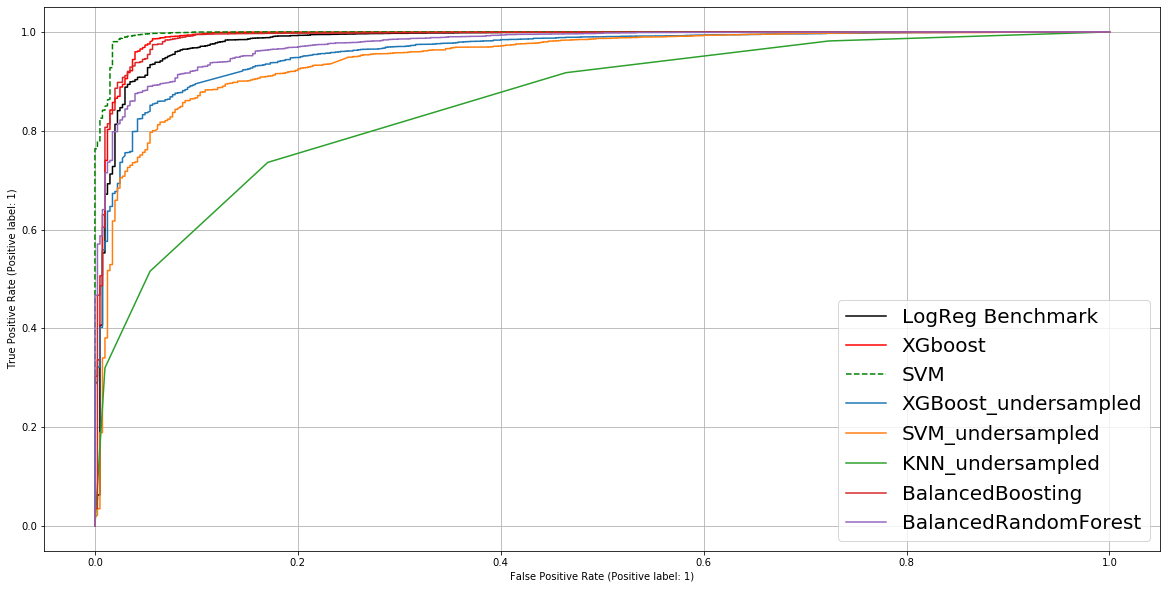

In [24]:
fig, ax = plt.subplots(figsize=(20,10))
plot_roc_curve(optimizerLR, X_test, y_test, ax=ax,color='black')
plot_roc_curve(optimizerXGB, X_test, y_test, ax=ax, color='red')
plot_roc_curve(optimizerSVM, X_test, y_test, ax=ax, color='green', linestyle='--')
plot_roc_curve(optimizerXGB_US, X_test, y_test, ax=ax)
plot_roc_curve(optimizerSVM_US, X_test, y_test, ax=ax)
plot_roc_curve(optimizerKNN_US, X_test, y_test, ax=ax)
plot_roc_curve(optimizerBB, X_test, y_test, ax=ax)
plot_roc_curve(optimizerBRF, X_test, y_test, ax=ax)

ax.legend(['LogReg Benchmark', 'XGboost', 'SVM', 'XGBoost_undersampled', 'SVM_undersampled','KNN_undersampled','BalancedBoosting', 'BalancedRandomForest'], fontsize=20)
ax.grid(b=True)
plt.show()

__Conclusion: The best model is SVM without data balancing__

In [25]:
final_model_binary = optimizerSVM

__Adjusting probability threshold__ <br>

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, final_model_binary.predict_proba(X_test)[:, 1])

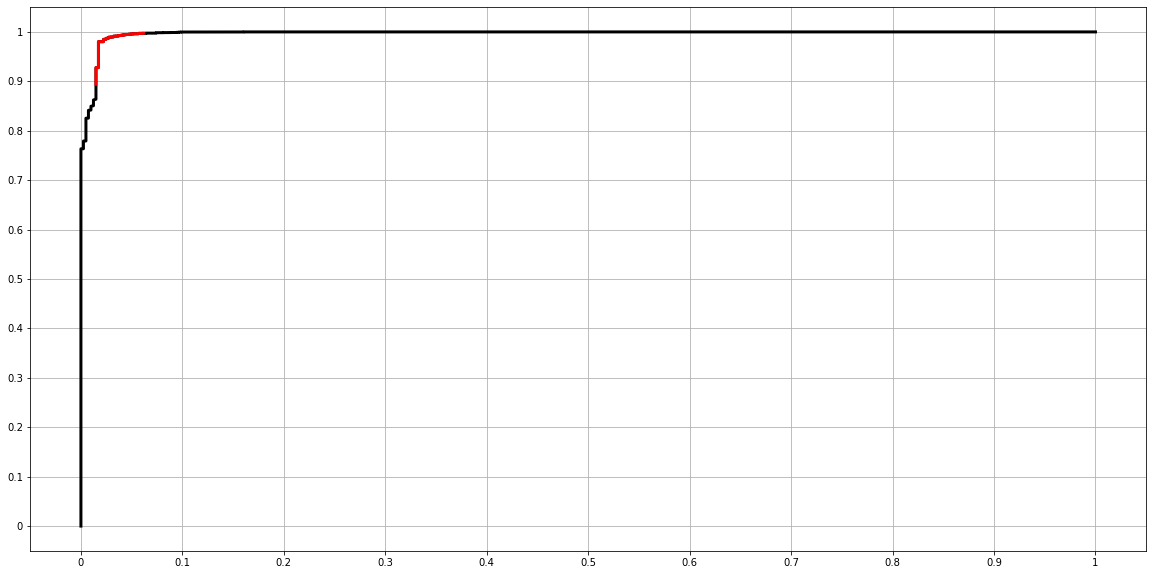

In [35]:
s, e = 150, 190
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(fpr, tpr, color='black', lw=3)
#red curve for determining threshold
ax.plot(fpr[s:e], tpr[s:e], color='red', lw=3)
ax.grid(which='both')
plt.yticks(ticks=np.arange(0,1.1,0.1), labels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=np.arange(0,1.1,0.1), labels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.show()

In [42]:
# printing values calculated in roc_cuvre in order to select threshold
# np.hstack([tpr.reshape(-1, 1),fpr.reshape(-1, 1), thresholds.reshape(-1, 1)])[s:e]

In [38]:
threshold = 0.8

y_pred_proba_pos = final_model_binary.predict_proba(X_test)[:,1]
y_pred = np.where(y_pred_proba_pos > threshold, 1, -1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

print(f'number of reviews that are positive and are predicted as positive: {cm[1][1]}')
print(f'number of reviews that are negative and are predicted as negative: {cm[0][0]}')
print(f'number of reviews that are negative and are predicted as positive: {cm[0][1]}')
print(f'number of reviews that are positive and are predicted as negative: {cm[1][0]}')

[[ 386   19]
 [  41 8416]]
              precision    recall  f1-score   support

          -1       0.90      0.95      0.93       405
           1       1.00      1.00      1.00      8457

    accuracy                           0.99      8862
   macro avg       0.95      0.97      0.96      8862
weighted avg       0.99      0.99      0.99      8862

number of reviews that are positive and are predicted as positive: 8416
number of reviews that are negative and are predicted as negative: 386
number of reviews that are negative and are predicted as positive: 19
number of reviews that are positive and are predicted as negative: 41


# 2. Multilabel classification
__The reviews are divided into three groups: positive, negative and neutral__

In [68]:
def model_summary(model, X_test, y_test):
    """
    Function that prints classification report and confusion matrix for a given model
    """
    
    y_pred = model.predict(X_test)
    print('\nconfusion matrix\n', confusion_matrix(y_test, y_pred))

    print('\nclassification report\n',classification_report(y_test, y_pred))

In [69]:
X = data.loc[:, 'review']
y = data.loc[:, 'rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## 2.1. No operations regarding class imbalance

### 2.1.1. Benchmark model - Logistic Regression 

In [70]:
modelLR_MC = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df)),
    ("model", LogisticRegression(max_iter=10_000, penalty='l2'))
])

paramsLR_MC = { "tfidf_vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
                "model__C": [0.1, 1, 10],
                "model__class_weight":[{-1:1, 0:1, 1:1}, {-1:10, 0:10, 1:1}]}

optimizerLR_MC = GridSearchCV(modelLR_MC, paramsLR_MC, cv=10, scoring='f1_weighted')

optimizerLR_MC2 = GridSearchCV(modelLR_MC, paramsLR_MC, cv=10, scoring='f1_micro')

optimizerLR_MC3 = GridSearchCV(modelLR_MC, paramsLR_MC, cv=10, scoring='f1_macro')

if load:
    optimizerLR_MC = pickle.load(open("models/211LogReg_benchamrk_MC1.pkl", 'rb'))
    optimizerLR_MC2 = pickle.load(open("models/211LogReg_benchamrk_MC2.pkl", 'rb'))
    optimizerLR_MC3 = pickle.load(open("models/211LogReg_benchamrk_MC3.pkl", 'rb'))
else:
    optimizerLR_MC.fit(X_train, y_train)
    optimizerLR_MC2.fit(X_train, y_train)
    optimizerLR_MC3.fit(X_train, y_train)

### 2.1.2. XGBoost

In [71]:
modelXGB_MC = Pipeline([
        ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1,2))),
        ("model", XGBClassifier(objective='multi:softmax', max_depth=30, n_estimators=500, num_class=3, n_jobs=-1))
])

paramsXGB_MC = {
                "model__reg_lambda":[0.1, 1, 10],
                "model__learning_rate":[0.01, 0.1, 0.5, 0.9],
               }

optimizerXGB_MC = GridSearchCV(modelXGB_MC, paramsXGB_MC, cv=5, scoring='f1_weighted')
if load:
    optimizerXGB_MC = pickle.load(open("models/212XGB.pkl", 'rb'))
else:
    optimizerXGB_MC.fit(X_train, y_train)

### 2.1.3. SVM

In [72]:
modelSVM_MC = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1,2))),
    ("model", SVC(probability=True, kernel='rbf'))
])

paramsSVM_MC = {"model__C":[0.1, 1, 10]}

optimizerSVM_MC = GridSearchCV(modelSVM_MC, paramsSVM_MC, cv=5, scoring='f1_weighted')

if load:
    optimizerSVM_MC = pickle.load(open("models/213SVM.pkl", 'rb'))
else:
    optimizerSVM_MC.fit(X_train, y_train)

## 2.2. Undersampling

In [73]:
data_train = pd.concat([X_train, y_train], axis=1)

data_minor = data_train[data_train['rating'] == -1]
data_neutral = data_train[data_train['rating'] == 0]

minor_size = data_minor.shape[0]
data_major = data_train[data_train['rating'] == 1].sample(n=minor_size)

data_train2 = pd.concat([data_minor, data_neutral, data_major])
X_train_us = data_train2.loc[:, 'review']
y_train_us = data_train2.loc[:, 'rating']

In [74]:
y_train_us.value_counts()

-1    1621
 1    1621
 0    1153
Name: rating, dtype: int64

### 2.2.1. XGBoost

In [75]:
modelXGB_MC_US = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1,2))),
    ("model", XGBClassifier(objective='multi:softmax', max_depth=30, num_class=3, n_jobs=-1))
])

paramsXGB_MC_US = {
                   "model__n_estimators":[100, 300, 500],
                   "model__reg_lambda":[0.1, 1, 10],
                   "model__learning_rate":[0.01, 0.1, 0.5, 0.9],
                  }

optimizerXGB_MC_US = GridSearchCV(modelXGB_MC_US, paramsXGB_MC_US, cv=10, scoring='f1_macro')
if load:
    optimizerXGB_MC_US = pickle.load(open("models/221XGB.pkl", 'rb'))
else:
    optimizerXGB_MC_US.fit(X_train, y_train)

### 2.2.2. SVM

In [76]:
modelSVM_MC_US = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=2, max_df=0.1)),
    ("model", SVC())
])

paramsSVM_MC_US = {"tfidf_vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
                   "model__C":[0.1, 1, 10],
                   "model__kernel":['rbf','poly','linear'],
                   "model__degree":[1,2,3,4,5,6,7],
                  }

optimizerSVM_MC_US = GridSearchCV(modelSVM_MC_US, paramsSVM_MC_US, cv=10, scoring='f1_weighted')
if load:
    optimizerSVM_MC_US = pickle.load(open("models/222SVM.pkl", 'rb'))
else:
    optimizerSVM_MC_US.fit(X_train, y_train)

### 2.2.3. KNN

In [77]:
modelKNN_MC_US = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=2, max_df=0.1)),
    ("model", KNeighborsClassifier())
])

paramsKNN_MC_US = {"tfidf_vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
                   "model__n_neighbors":[3, 5, 10, 15]
                  }

optimizerKNN_MC_US = GridSearchCV(modelKNN_MC_US, paramsKNN_MC_US, cv=10, scoring='f1_weighted')
if load:
    optimizerKNN_MC_US = pickle.load(open("models/223KNN.pkl", 'rb'))
else:
    optimizerKNN_MC_US.fit(X_train, y_train)

## 2.3. Imblearn library
__library dedicated for imbalanced problems__

### 2.3.1. Balanced Random Forest

In [78]:
modelBRF_MC = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1, 2))),
    ("model", BalancedRandomForestClassifier(replacement=True))
])

paramsBRF_MC = {"model__max_depth": [10, 25],
                "model__n_estimators": [100, 200, 500],
                "model__class_weight": [{1:1, -1:1, 0:1}, {1:1, -1:10, 0:10}, {1:1, -1:20, 0:20}]}

optimizerBRF_MC = GridSearchCV(modelBRF_MC, paramsBRF_MC, cv=5, scoring='f1_weighted')
if load:
    optimizerBRF_MC = pickle.load(open("models/231BRF.pkl", 'rb'))
else:
    optimizerBRF_MC.fit(X_train, y_train)

### 2.3.2. Balanced Boosting

In [79]:
modelBB_MC = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1,2))),
    ("model", RUSBoostClassifier(replacement=True))
])


paramsBB_MC = {"model__base_estimator": [LogisticRegression(max_iter=10_000, penalty='none'), 
                                      LogisticRegression(max_iter=10_000, penalty='l2', C=10, class_weight={1:1, -1:10}),
                                      DecisionTreeClassifier(max_depth=15),
                                      KNeighborsClassifier(n_neighbors=5)],
            "model__learning_rate": [0.01, 0.1, 1],
            "model__n_estimators": [100, 200, 500]}



if load:
    optimizerBB_MC = pickle.load(open("models/232BB.pkl", 'rb'))
else:
    optimizerBB_MC.fit(X_train, y_train)

## Multiclass models evaluation

__There is no ROC for multiclass problem, the best model was selected by confusion matrix and classification report - precision, recall and f1-score for minor classes__

In [80]:
models = [(optimizerLR_MC, 'LR_MC'),
          (optimizerLR_MC2, 'LR_MC2'),
          (optimizerLR_MC3, 'LR_MC3'),
          (optimizerXGB_MC, 'XGB_MC'),
          (optimizerSVM_MC, 'SVM_MC'),
          (optimizerXGB_MC_US, 'XGB_undersampled'),
          (optimizerSVM_MC_US, 'SVM_undersampled'),
          (optimizerBRF_MC, 'BRF'),
          (optimizerBB_MC, 'BB')]

for m in models:
    print(f'model {m[1]}')
    model_summary(m[0], X_test, y_test)
    print()

model LR_MC

confusion matrix
 [[ 300   11   94]
 [  31   83  175]
 [  34   34 8389]]

classification report
               precision    recall  f1-score   support

          -1       0.82      0.74      0.78       405
           0       0.65      0.29      0.40       289
           1       0.97      0.99      0.98      8457

    accuracy                           0.96      9151
   macro avg       0.81      0.67      0.72      9151
weighted avg       0.95      0.96      0.95      9151


model LR_MC2

confusion matrix
 [[ 232    3  170]
 [  34   24  231]
 [  17   11 8429]]

classification report
               precision    recall  f1-score   support

          -1       0.82      0.57      0.67       405
           0       0.63      0.08      0.15       289
           1       0.95      1.00      0.98      8457

    accuracy                           0.95      9151
   macro avg       0.80      0.55      0.60      9151
weighted avg       0.94      0.95      0.94      9151


model LR_MC3

c

__Final summary can be found in `Final_model_summary.ipynb` notebook__

In [ ]:
# if not load:

#     with open('111LogReg_benchamrk.pkl','wb') as f:
#         pickle.dump(optimizerLR,f)
#     f.close()

#     with open('112XGB.pkl','wb') as f:
#         pickle.dump(optimizerXGB,f)
#     f.close()    

#     with open('113SVM.pkl','wb') as f:
#         pickle.dump(optimizerSVM,f)
#     f.close()    

#     with open('121XBG.pkl','wb') as f:
#         pickle.dump(optimizerXGB_US,f)
#     f.close()    

#     with open('122SVM.pkl','wb') as f:
#         pickle.dump(optimizerSVM_US,f)
#     f.close()    

#     with open('123KNN.pkl','wb') as f:
#         pickle.dump(optimizerKNN_US,f)
#     f.close()    

#     with open('131BRF.pkl','wb') as f:
#         pickle.dump(optimizerBRF,f)
#     f.close()    

#     with open('132BB.pkl','wb') as f:
#         pickle.dump(optimizerBB,f)
#     f.close()
#     with open('211LogReg_benchamrk_MC1.pkl','wb') as f:
#         pickle.dump(optimizerLR_MC,f)
#     f.close()

#     with open('211LogReg_benchamrk_MC2.pkl','wb') as f:
#         pickle.dump(optimizerLR_MC2,f)
#     f.close()

#     with open('211LogReg_benchamrk_MC3.pkl','wb') as f:
#         pickle.dump(optimizerLR_MC3,f)
#     f.close()

#     with open('212XGB.pkl','wb') as f:
#         pickle.dump(optimizerXGB_MC,f)
#     f.close()

#     with open('221XGB.pkl','wb') as f:
#         pickle.dump(optimizerXGB_MC_US,f)
#     f.close()

#     with open('222SVM.pkl','wb') as f:
#         pickle.dump(optimizerSVM_MC_US,f)
#     f.close()

#     with open('223KNN.pkl','wb') as f:
#         pickle.dump(optimizerKNN_MC_US,f)
#     f.close()

#     with open('231BRF.pkl','wb') as f:
#         pickle.dump(optimizerBRF_MC,f)
#     f.close()

#     with open('232BB.pkl','wb') as f:
#         pickle.dump(optimizerBB_MC,f)
#     f.close()